In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
# Current folder containing the data
data_folder = Path("./")

files = sorted(data_folder.glob("listings_*_2025.csv"))

dfs = []

for f in files:
    # Extract the month name between "listings_" and "_2025"
    month_str = f.stem.split("_")[1]

    df = pd.read_csv(f)

    df["month"] = month_str

    dfs.append(df)
# Create a larger, full dataframe containing all months for 2025
full_df = pd.concat(dfs, ignore_index=True)

print("Loaded files:")
for f in files:
    print(" -", f.name)

print("\nFinal combined shape:", full_df.shape)

Loaded files:
 - listings_April_2025.csv
 - listings_August_2025.csv
 - listings_February_2025.csv
 - listings_January_2025.csv
 - listings_July_2025.csv
 - listings_June_2025.csv
 - listings_March_2025.csv
 - listings_May_2025.csv
 - listings_October_2025.csv
 - listings_September_2025.csv

Final combined shape: (368542, 80)


In [ ]:
pd.set_option('display.max_columns', None)
display(full_df)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,month
0,2539,https://www.airbnb.com/rooms/2539,20250401230149,2025-04-02,city scrape,Superfast Wi-Fi. Clean & quiet home by the park,Renovated apt home in elevator building.,Close to Prospect Park and Historic Ditmas Park,https://a0.muscache.com/pictures/3949d073-a02e...,2787,https://www.airbnb.com/users/show/2787,John,2008-09-07,"New York, NY",Educated professional living in Brooklyn. I l...,within an hour,100%,81%,f,https://a0.muscache.com/im/pictures/user/86745...,https://a0.muscache.com/im/pictures/user/86745...,Gravesend,4.0,13.0,"['email', 'phone']",t,t,Neighborhood highlights,Kensington,Brooklyn,40.645290,-73.972380,Private room in rental unit,Private room,2,1.0,1 private bath,1.0,1.0,"[""Microwave"", ""Portable fans"", ""Free street pa...",$128.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,23,53,83,358,2025-04-02,9,0,0,267.0,0.0,0.0,0.0,2015-12-04,2018-10-19,4.89,4.88,5.00,5.00,5.00,4.75,4.88,NaN,f,4,0,4,0,0.08,April
1,6872,https://www.airbnb.com/rooms/6872,20250401230149,2025-04-02,city scrape,Uptown Sanctuary w/ Private Bath (Month to Month),This charming distancing-friendly month-to-mon...,This sweet Harlem sanctuary is a 10-20 minute ...,https://a0.muscache.com/pictures/miso/Hosting-...,16104,https://www.airbnb.com/users/show/16104,Kahshanna,2009-05-07,"New York, NY",A former life in fashion and wellness has left...,within a few hours,100%,33%,f,https://a0.muscache.com/im/pictures/user/d865a...,https://a0.muscache.com/im/pictures/user/d865a...,East Harlem,2.0,2.0,"['email', 'phone', 'work_email']",t,f,Neighborhood highlights,East Harlem,Manhattan,40.801070,-73.942550,Private room in condo,Private room,1,1.0,1 shared bath,1.0,1.0,"[""Dryer"", ""Elevator"", ""Hangers"", ""Hot water"", ...",$59.00,30,180,30.0,30.0,180.0,180.0,30.0,180.0,NaN,t,23,53,83,83,2025-04-02,1,0,0,83.0,0.0,0.0,0.0,2022-06-05,2022-06-05,5.00,5.00,5.00,5.00,5.00,5.00,5.00,NaN,f,2,0,2,0,0.03,April
2,7064,https://www.airbnb.com/rooms/7064,20250401230149,2025-04-02,previous scrape,"Amazing location! Wburg. Large, bright & tranquil","Large, private loft-like room in a spacious 2-...","- One stop from the East Village, Lower East S...",https://a0.muscache.com/pictures/13708959/7e74...,17297,https://www.airbnb.com/users/show/17297,Joelle,2009-05-15,"New York, NY",I have lived in the same apartment in Brooklyn...,a few days or more,0%,0%,f,https://a0.muscache.com/im/users/17297/profile...,https://a0.muscache.com/im/users/17297/profile...,Williamsburg,2.0,2.0,"['email', 'phone', 'work_email']",t,t,Neighborhood highlights,Williamsburg,Brooklyn,40.712480,-73.958810,Pr

# Let's preprocess some of the data

In [ ]:
# Remove the dollar sign from the price column to prevent errors later
full_df['price'] = full_df['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
full_df['price'] = pd.to_numeric(full_df['price'], errors='coerce')

month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

full_df['month_num'] = full_df['month']
full_df['month_num'] = full_df['month_num'].map(month_mapping)

print(full_df.columns)
print(full_df.describe())

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [ ]:
full_df = full_df[full_df['price'] < 5000]

In [ ]:
# Calculate count, mean, median, std for boroughs
def calculate_rental_stats(df):
  """
    Calculates mean, median, standard deviation on pandas dataframe containing differently monthly price data.

    param1: (pandas df) to compute statistics on

    returns: (pandas df) with mean, median, std columns
  """
  # Use the groupby and aggregate methods from pandas to calculate basic statistics
  stats_per_month = df.groupby('month_num')['price'].agg(['count', 'mean', 'median', 'std']).sort_index()

  # Use the pandas to_datetime as an easy way to convert numbers back to months in a lambda function
  stats_per_month['month'] = stats_per_month.index.map(lambda x: pd.to_datetime(str(x), format='%m').month_name())

  return stats_per_month

monthly_stats = calculate_rental_stats(full_df)
display(
    monthly_stats.style
        .format({'count':'{:,.0f}', 'mean':'{:,.2f}', 'median':'{:,.2f}', 'std':'{:,.2f}'})
        .background_gradient(cmap='Blues', subset=['median'])
        .background_gradient(cmap='Greens', subset=['mean'])
)

,count,mean,median,std,month
month_num,,,,,
1,"22,956",189.40,132.00,231.57,January
2,"23,178",187.13,130.00,227.18,February
3,"22,289",204.41,140.00,246.46,March
4,"22,108",212.27,145.00,251.65,April
5,"21,814",223.84,150.00,268.09,May
6,"21,295",224.95,152.00,268.87,June
7,"21,163",220.57,151.00,261.62,July
8,"21,155",219.76,150.00,261.18,August
9,"21,010",231.15,150.00,276.80,September


In [ ]:
# Let's see how much more expensive Manhattan is compared to the rest

# Average price in Manhattan
manhattan_avg = full_df[full_df['neighbourhood_group_cleansed'] == "Manhattan"]['price'].mean()

# Average price in all other boroughs (exclude Manhattan)
other_boroughs_avg = full_df[full_df['neighbourhood_group_cleansed'] != "Manhattan"]['price'].mean()

print("Average price in Manhattan:", manhattan_avg)
print("Average price in other boroughs:", other_boroughs_avg)

# Optional comparison table
comparison = pd.DataFrame({
    "Manhattan_avg_price": [manhattan_avg],
    "Other_boroughs_avg_price": [other_boroughs_avg]
})

print("\nComparison table:")
print(comparison)

print(manhattan_avg / other_boroughs_avg)

Average price in Manhattan: 288.52671164237086
Average price in other boroughs: 153.92840591422234

Comparison table:
   Manhattan_avg_price  Other_boroughs_avg_price
0           288.526712                153.928406
1.874421487890639


In [ ]:
ultra = full_df[full_df['price'] > 1000]

ultra_counts = ultra['neighbourhood_group_cleansed'].value_counts()
ultra_counts


,count
neighbourhood_group_cleansed,
Manhattan,2406
Brooklyn,382
Queens,92
Staten Island,21
Bronx,15


In [ ]:
full_df.groupby('neighbourhood_group_cleansed')['price'].std().sort_values(ascending=False)


,price
neighbourhood_group_cleansed,
Manhattan,319.728187
Brooklyn,189.842859
Queens,136.866253
Staten Island,132.776839
Bronx,106.376617


In [ ]:
zero_count = full_df[full_df['price'] == 0].shape[0]
print(zero_count)


0


# Let's visualize the distribution of prices per borough using histograms.

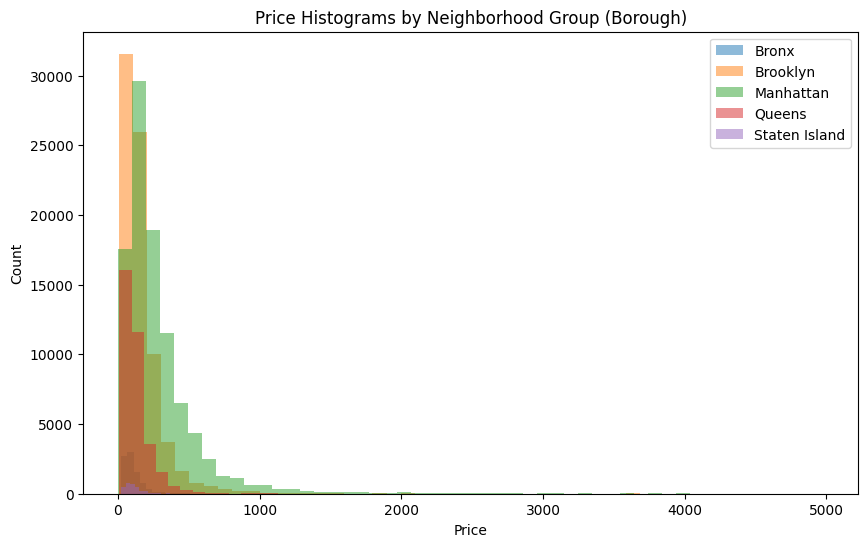

In [ ]:
# df = full_df[full_df['month'] == 'October']
df = full_df
prices_per_borough = df[['neighbourhood_group_cleansed', 'price']]

plt.figure(figsize=(10,6))

for group, subset in df.groupby("neighbourhood_group_cleansed"):
    plt.hist(subset["price"].dropna(), bins=50, alpha=0.5, label=group)

plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Price Histograms by Neighborhood Group (Borough)")
plt.legend()
plt.show()

# Plot on log scale so outliers don't ruin graph

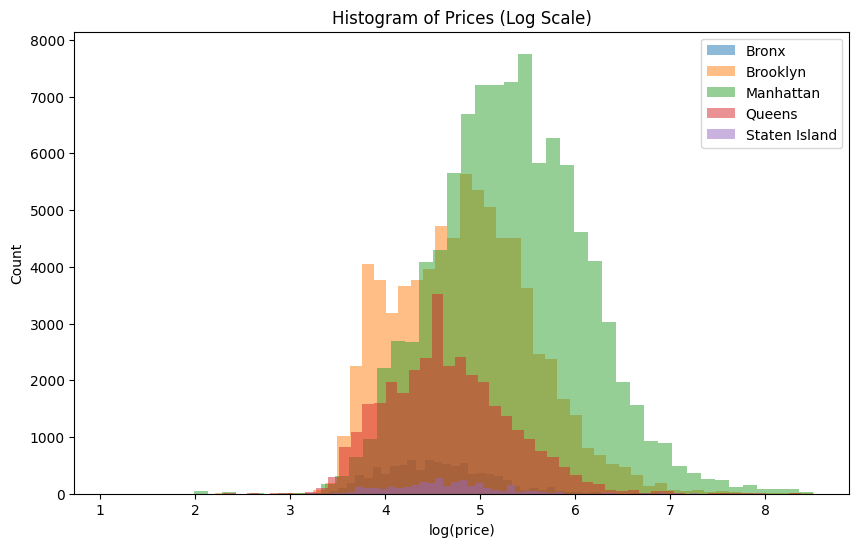

In [ ]:
plt.figure(figsize=(10,6))
for group, subset in df.groupby("neighbourhood_group_cleansed"):
    plt.hist(np.log(subset["price"]), bins=50, alpha=0.5, label=group)

plt.xlabel("log(price)")
plt.ylabel("Count")
plt.title("Histogram of Prices (Log Scale)")
plt.legend()
plt.show()

# Zoom in on Manhattan specifically, separating by neighbourhoods

32

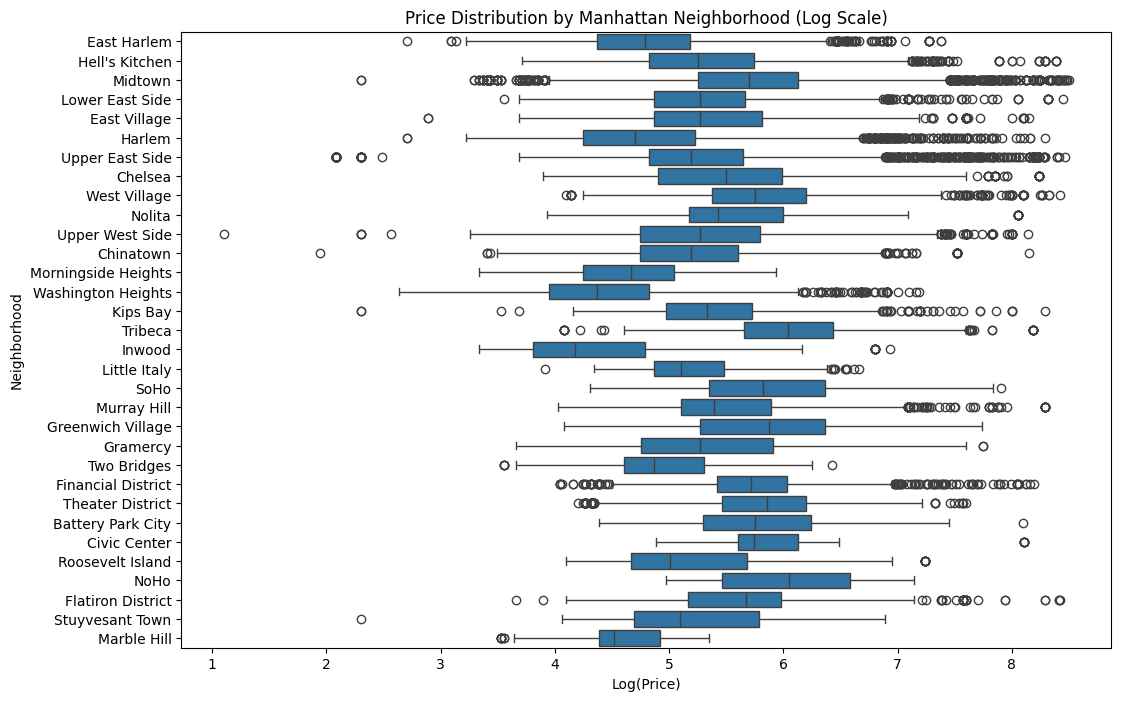

/tmp/ipython-input-2894278923.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


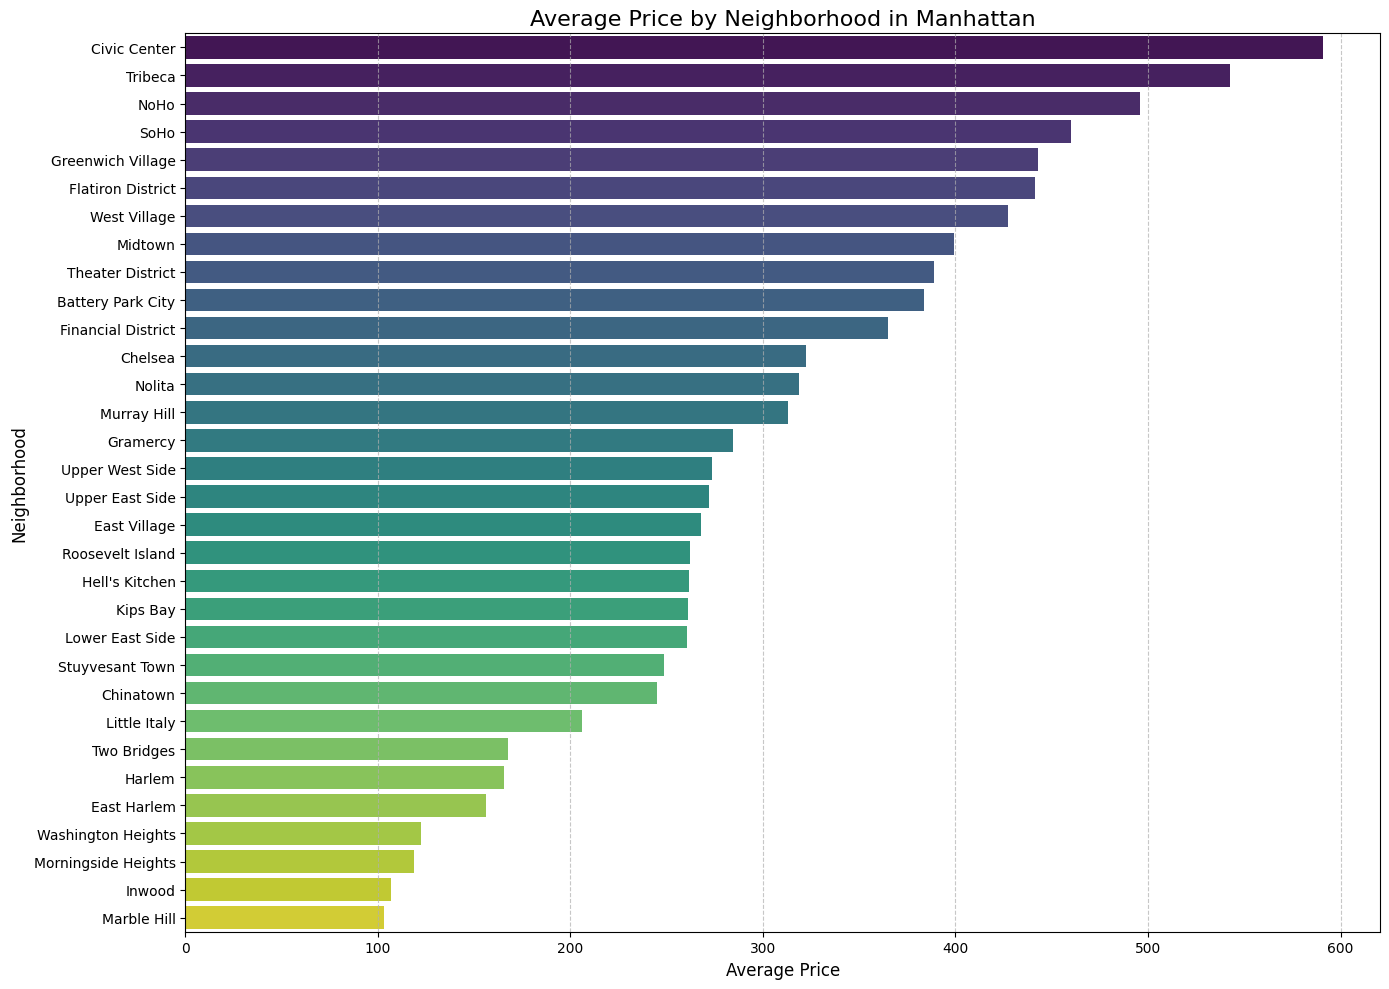

In [ ]:
display(df[df['neighbourhood_group_cleansed'] == 'Manhattan']['neighbourhood_cleansed'].nunique())

manhattan_borough = df[df["neighbourhood_group_cleansed"] == "Manhattan"].copy()

manhattan_borough['log_price'] = np.log(manhattan_borough['price'])

plt.figure(figsize=(12,8))
sns.boxplot(data=manhattan_borough, x="log_price", y="neighbourhood_cleansed")

plt.title("Price Distribution by Manhattan Neighborhood (Log Scale)")
plt.xlabel("Log(Price)")
plt.ylabel("Neighborhood")
plt.show()

# Calculate the mean price for each Manhattan neighborhood again for clarity
manhattan_mean_by_neighbourhood = manhattan_borough.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(14, 10))
sns.barplot(
    x='price',
    y='neighbourhood_cleansed',
    data=manhattan_mean_by_neighbourhood,
    palette='viridis'
)

plt.title('Average Price by Neighborhood in Manhattan', fontsize=16)
plt.xlabel('Average Price', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
manhattan_mean_by_neighbourhood = manhattan_borough.groupby('neighbourhood_cleansed')['price'].mean()
manhattan_range = (manhattan_mean_by_neighbourhood.max() - manhattan_mean_by_neighbourhood.min()) / manhattan_mean_by_neighbourhood.min() * 100
manhattan_range

472.7676702189446

In [ ]:
manhattan_mean_by_neighbourhood.std()


128.75274001916483

In [ ]:
manhattan_borough['neighbourhood_cleansed'].value_counts()


,count
neighbourhood_cleansed,
Midtown,13615
Harlem,10170
Upper East Side,9875
Hell's Kitchen,9742
Upper West Side,8273
Chelsea,5279
East Village,4417
East Harlem,3978
Financial District,3540


# Heatmap of Manhattan

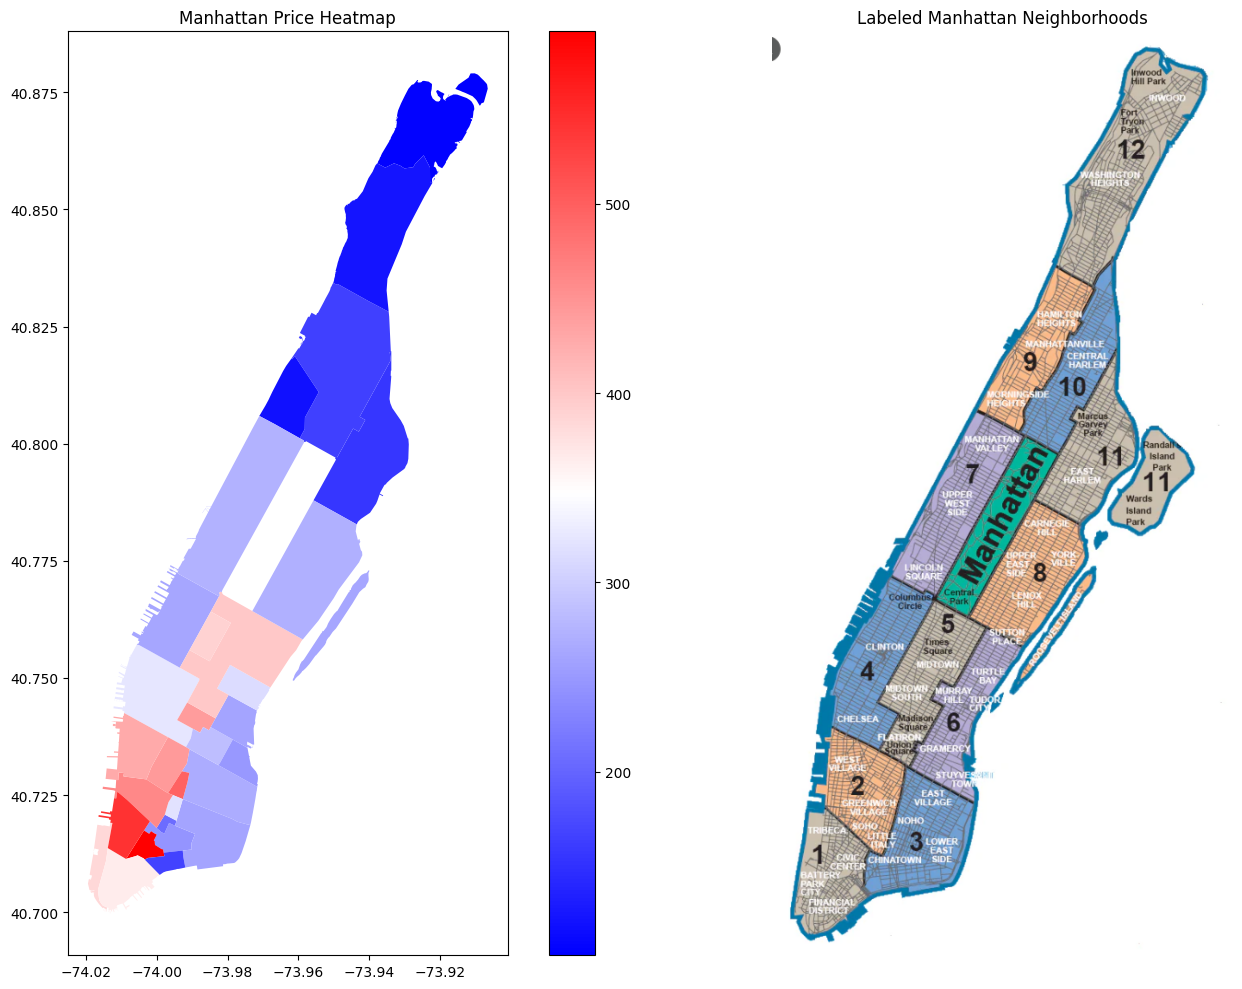

In [ ]:
nyc_map = gpd.read_file("neighbourhoods_October_2025.geojson")
manhattan_map = nyc_map[nyc_map["neighbourhood_group"] == "Manhattan"]

# Average price per neighborhood
avg_price = df.groupby("neighbourhood_cleansed")["price"].mean().reset_index()

merged = manhattan_map.merge(avg_price, left_on="neighbourhood", right_on="neighbourhood_cleansed")

labeled_map = plt.imread("manhattan_neighborhoods.png")

fig, axes = plt.subplots(1, 2, figsize=(16,10))

merged.plot(
    column="price",
    cmap="bwr",
    legend=True,
    ax=axes[0]
)
axes[0].set_title("Manhattan Price Heatmap")

axes[1].imshow(labeled_map)
axes[1].axis("off")
axes[1].set_title("Labeled Manhattan Neighborhoods")

plt.tight_layout()
plt.show()

# Show Correlation Matrix of variables related to price

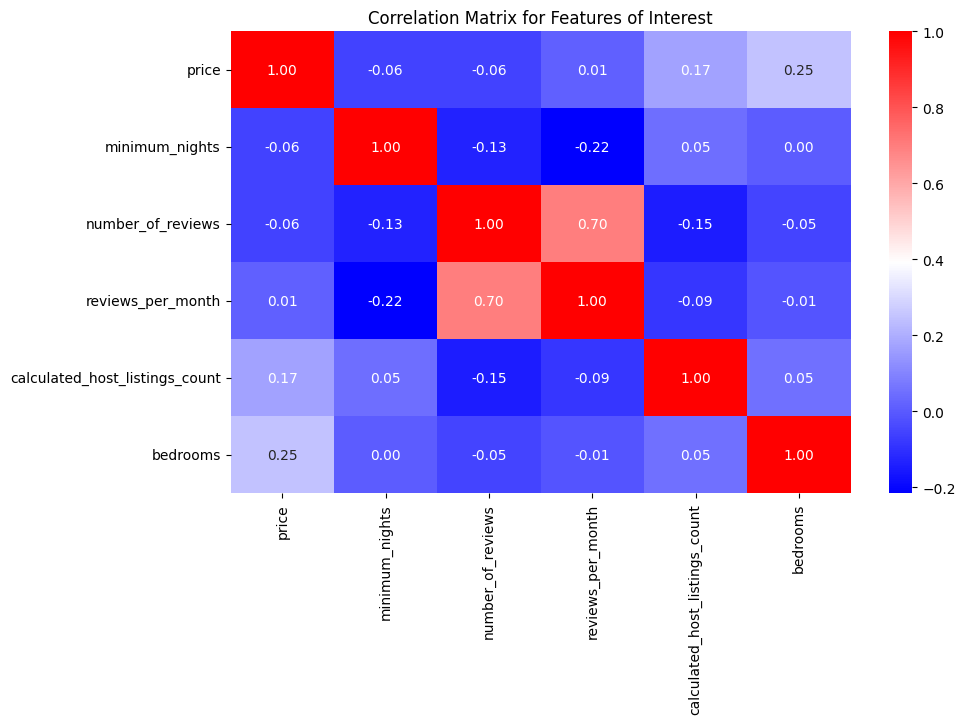

In [ ]:
cols_of_interest = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'bedrooms']

corr = full_df[cols_of_interest].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='bwr')
plt.title('Correlation Matrix for Features of Interest')
plt.show()

# Let's check how price changes over seasons

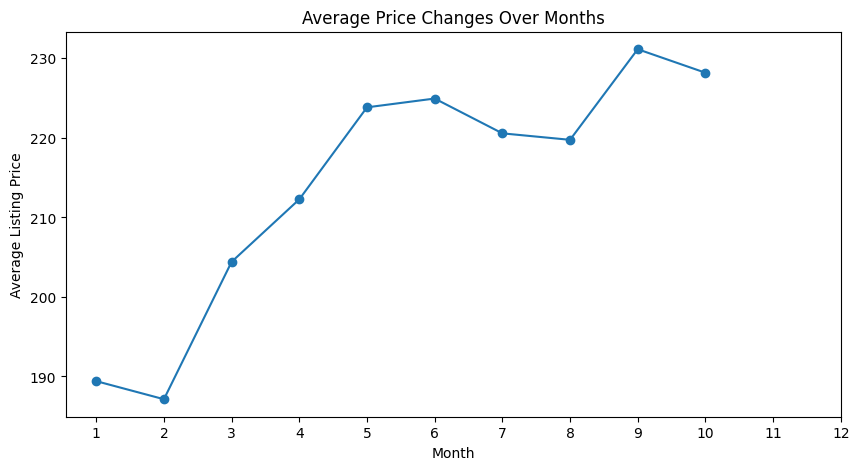

In [ ]:
average_price_monthly = (full_df.groupby('month_num')['price'].mean().reset_index().sort_values('month_num'))

plt.figure(figsize=(10,5))
plt.plot(average_price_monthly['month_num'], average_price_monthly['price'], marker="o")
plt.title('Average Price Changes Over Months')
plt.xlabel('Month')
plt.ylabel('Average Listing Price')
plt.xticks(range(1, 13))
plt.show()

In [ ]:
monthly_avg = full_df.groupby('month_num')['price'].mean()

pct_range = (monthly_avg.max() - monthly_avg.min()) / monthly_avg.min() * 100
pct_range



23.525030703716475

In [ ]:
luxury = full_df[full_df['price'] > 1000]
luxury.groupby('month_num').size()


,0
month_num,
1,227
2,219
3,286
4,280
5,316
6,315
7,306
8,287
9,343
